# Model Comparison — Neural Networks + Boosting

This notebook compares **all available model prediction files** on the **same labeled holdout set** (matched by `UNIQUEID` and `y_true`).

It supports:
- Neural networks:
  - `results/nn_baseline_test_preds.csv`
  - `results/nn_improved_test_preds.csv`
- Boosting (from `03_boosting.ipynb`):
  - `results/boosting_best_test_preds.csv` (recommended aggregate/best)
  - (optional) per-model files if you exported them:
    - `results/boosting_xgb_test_preds.csv`
    - `results/boosting_lgbm_test_preds.csv`
    - `results/boosting_cat_test_preds.csv`

All files must contain **the same rows** (same `UNIQUEID`s) for an apples-to-apples comparison.

**Expected columns in each prediction file**
- `UNIQUEID`
- `y_true` (0/1)
- `y_prob` (predicted probability of default)

---

## What this notebook does
1. Loads all prediction files that exist (you can toggle models with `ENABLED_MODELS`).
2. Inner-joins them on (`UNIQUEID`, `y_true`) to ensure a strict same-row comparison.
3. Computes metrics at a shared threshold (default `t=0.50`).
4. Plots ROC curves for all included models.


In [16]:
import os
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    log_loss,
    brier_score_loss,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    balanced_accuracy_score,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
)


import matplotlib.pyplot as plt

# Paths
RESULTS_DIR = Path('..') / 'results'

PRED_FILES = {
    # Neural nets
    "NN - Baseline MLP": RESULTS_DIR / "nn_baseline_test_preds.csv",
    "NN - Improved MLP": RESULTS_DIR / "nn_improved_test_preds.csv",

    # Boosting (best/aggregate)
    "Boosting - Best": RESULTS_DIR / "boosting_best_test_preds.csv",
    "Boosting - XGBoost": RESULTS_DIR / "boosting_xgb_test_preds.csv",
    "Boosting - LightGBM": RESULTS_DIR / "boosting_lgbm_test_preds.csv",
    "Boosting - CatBoost": RESULTS_DIR / "boosting_cat_test_preds.csv",
}

ENABLED_MODELS = {
    "NN - Baseline MLP": True,
    "NN - Improved MLP": True,
    "Boosting - Best": True,
    "Boosting - XGBoost": True,
    "Boosting - LightGBM": True,
    "Boosting - CatBoost": True,
}

ID_COL = "UNIQUEID"
REQUIRED_COLS = {ID_COL, "y_true", "y_prob"}


In [17]:
def _load_preds(label: str, path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    missing = REQUIRED_COLS - set(df.columns)
    assert not missing, f"{label} file missing columns: {missing} (path={path})"

    # Keep only what we need; enforce types lightly
    out = df[[ID_COL, "y_true", "y_prob"]].copy()
    out["y_true"] = out["y_true"].astype(int)
    out["y_prob"] = out["y_prob"].astype(float)
    return out


loaded = {}
skipped = []

for label, path in PRED_FILES.items():
    if not ENABLED_MODELS.get(label, False):
        skipped.append((label, "disabled"))
        continue
    if not path.exists():
        skipped.append((label, f"missing file: {path}"))
        continue

    loaded[label] = _load_preds(label, path)

print("Loaded models:", list(loaded.keys()))
if skipped:
    print("\nSkipped:")
    for label, reason in skipped:
        print(f" - {label}: {reason}")

assert len(loaded) >= 2, "Need at least 2 prediction files to compare."


Loaded models: ['NN - Baseline MLP', 'NN - Improved MLP', 'Boosting - XGBoost', 'Boosting - CatBoost']

Skipped:
 - Boosting - Best: missing file: ..\results\boosting_best_test_preds.csv
 - Boosting - LightGBM: missing file: ..\results\boosting_lgbm_test_preds.csv


In [18]:
items = list(loaded.items())

merged = items[0][1].rename(columns={"y_prob": f"y_prob__{items[0][0]}"})

for label, df in items[1:]:
    merged = merged.merge(
        df.rename(columns={"y_prob": f"y_prob__{label}"}),
        on=[ID_COL, "y_true"],
        how="inner",
    )

print("Row counts per file:")
for label, df in loaded.items():
    print(f" - {label}: {len(df):,}")

print("\nMatched rows (intersection across all loaded):", f"{len(merged):,}")

display(merged.head())


Row counts per file:
 - NN - Baseline MLP: 34,974
 - NN - Improved MLP: 34,974
 - Boosting - XGBoost: 34,974
 - Boosting - CatBoost: 34,974

Matched rows (intersection across all loaded): 34,974


,UNIQUEID,y_true,y_prob__NN - Baseline MLP,y_prob__NN - Improved MLP,y_prob__Boosting - XGBoost,y_prob__Boosting - CatBoost
0,490213,0,0.687483,0.673230,0.289268,0.301008
1,492995,1,0.841740,0.827259,0.525001,0.579186
2,586411,0,0.558664,0.559846,0.229255,0.242787
3,519075,0,0.468006,0.486597,0.178618,0.198091
4,525983,0,0.290159,0.284628,0.106982,0.107769


In [19]:
def metrics_at_threshold(y: np.ndarray, p: np.ndarray, t: float = 0.50) -> dict:
    yhat = (p >= t).astype(int)

    tn, fp, fn, tp = confusion_matrix(y, yhat).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    eps = 1e-15  # avoid log_loss issues with exact 0/1 probs
    p_clip = np.clip(p, eps, 1 - eps)

    return {
        "auc_roc": float(roc_auc_score(y, p)),
        "auc_pr": float(average_precision_score(y, p)),
        "log_loss": float(log_loss(y, p_clip)),
        "brier": float(brier_score_loss(y, p)),
        "accuracy": float(accuracy_score(y, yhat)),
        "balanced_acc": float(balanced_accuracy_score(y, yhat)),
        f"precision@{t:.2f}": float(precision_score(y, yhat, zero_division=0)),
        f"recall@{t:.2f}": float(recall_score(y, yhat, zero_division=0)),
        f"specificity@{t:.2f}": float(specificity),
        f"f1@{t:.2f}": float(f1_score(y, yhat, zero_division=0)),
        "tp": int(tp), "fp": int(fp), "tn": int(tn), "fn": int(fn),
    }

t = 0.50

y_true = merged["y_true"].astype(int).values

rows = {}
for label in loaded.keys():
    p = merged[f"y_prob__{label}"].values.astype(float)
    rows[label] = metrics_at_threshold(y_true, p, t=t)

summary = pd.DataFrame(rows).T.sort_values("auc_roc", ascending=False)
summary


,auc_roc,auc_pr,log_loss,brier,accuracy,balanced_acc,precision@0.50,recall@0.50,specificity@0.50,f1@0.50,tp,fp,tn,fn
Boosting - XGBoost,0.667515,0.345195,0.492870,0.159824,0.783525,0.509665,0.528455,0.025685,0.993645,0.048989,195.0,174.0,27208.0,7397.0
Boosting - CatBoost,0.666780,0.346149,0.493213,0.159857,0.783868,0.508599,0.554455,0.022129,0.995070,0.042559,168.0,135.0,27247.0,7424.0
NN - Baseline MLP,0.650593,0.325208,0.654173,0.232047,0.574055,0.608315,0.290820,0.668862,0.547769,0.405381,5078.0,12383.0,14999.0,2514.0
NN - Improved MLP,0.648562,0.323609,0.650185,0.229896,0.592269,0.604811,0.294045,0.626976,0.582646,0.400336,4760.0,11428.0,15954.0,2832.0


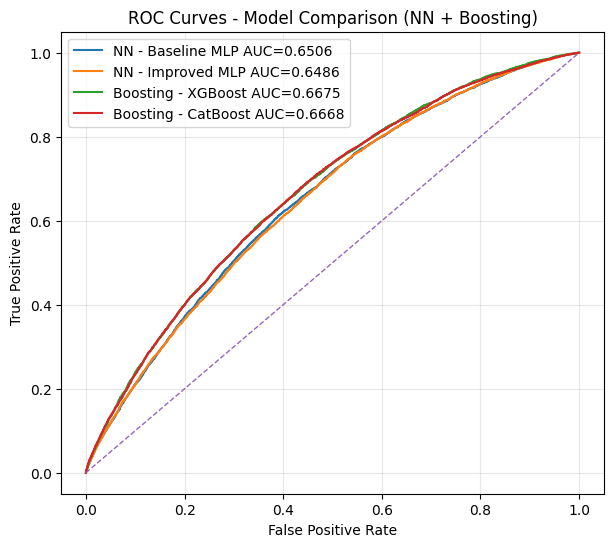

In [20]:
plt.figure(figsize=(7, 6))

for label in loaded.keys():
    p = merged[f"y_prob__{label}"].values.astype(float)
    fpr, tpr, _ = roc_curve(y_true, p)
    auc = roc_auc_score(y_true, p)
    plt.plot(fpr, tpr, label=f"{label} AUC={auc:.4f}")

plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Model Comparison (NN + Boosting)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


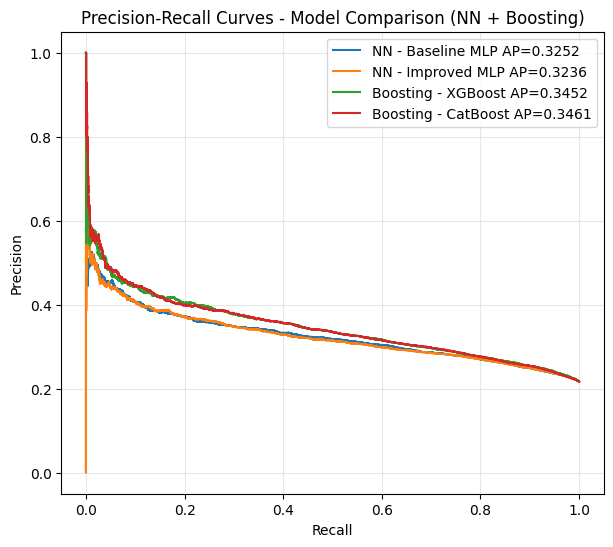

In [21]:
plt.figure(figsize=(7, 6))

for label in loaded.keys():
    p = merged[f"y_prob__{label}"].values.astype(float)
    prec, rec, _ = precision_recall_curve(y_true, p)
    ap = average_precision_score(y_true, p)
    plt.plot(rec, prec, label=f"{label} AP={ap:.4f}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves - Model Comparison (NN + Boosting)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [22]:
summary = pd.DataFrame(rows).T.sort_values(["auc_pr", "auc_roc"], ascending=False)
summary

,auc_roc,auc_pr,log_loss,brier,accuracy,balanced_acc,precision@0.50,recall@0.50,specificity@0.50,f1@0.50,tp,fp,tn,fn
Boosting - CatBoost,0.666780,0.346149,0.493213,0.159857,0.783868,0.508599,0.554455,0.022129,0.995070,0.042559,168.0,135.0,27247.0,7424.0
Boosting - XGBoost,0.667515,0.345195,0.492870,0.159824,0.783525,0.509665,0.528455,0.025685,0.993645,0.048989,195.0,174.0,27208.0,7397.0
NN - Baseline MLP,0.650593,0.325208,0.654173,0.232047,0.574055,0.608315,0.290820,0.668862,0.547769,0.405381,5078.0,12383.0,14999.0,2514.0
NN - Improved MLP,0.648562,0.323609,0.650185,0.229896,0.592269,0.604811,0.294045,0.626976,0.582646,0.400336,4760.0,11428.0,15954.0,2832.0
